# Title

In [125]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns

In [145]:
class Inputs():
    def __init__(self, nCS=5, nCTX=3, dim=2, seed=0):
        self.rng = np.random.RandomState(seed=seed)
        self.sampler = nengo.dists.UniformHypersphere(surface=True)
        self.dim = dim
        self.nCS = nCS
        self.nCTX = nCTX
        self.CSs = self.sampler.sample(nCS, dim, rng=self.rng)
        self.CTXs = self.sampler.sample(nCTX, dim, rng=self.rng)
        self.USs = self.rng.randint(2, size=nCS)
    def get_CS(self, t):
        idx = int(t) % self.nCS
        return self.CSs[idx]
    def get_CTX(self, t):
        idx = int(t) % self.nCS
        return self.CTX[idx]
    def get_US(self, t):
        idx = int(t) % self.nCS
        applied = True if t%1>0.5 else False
        return self.USs[idx] if applied else 0

In [149]:
seed = 0
dim = 2
nCS = 5
nNeurons = 100
net = nengo.Network(seed=seed)
inputs = Inputs(dim=dim, seed=7)
with net:
    CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
    US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
    LA = nengo.Ensemble(nNeurons, dim, intercepts=nengo.dists.Uniform(0.5,1))
    voja = nengo.Voja(learning_rate=1e-2, post_synapse=None)
    cCS = nengo.Connection(CS, LA, synapse=None, learning_rule_type=voja)
    cCoincident = nengo.Connection(US, cCS.learning_rule, synapse=None, function=lambda x: x-1)
    pEncoders = nengo.Probe(cCS.learning_rule, "scaled_encoders")

In [150]:
sim = nengo.Simulator(net)
with sim:
    sim.run(5)

scale = (sim.data[LA].gain / LA.radius)[:, np.newaxis]
encoders_before = sim.data[pEncoders][0].copy() / scale
encoders_after = sim.data[pEncoders][-1].copy() / scale

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

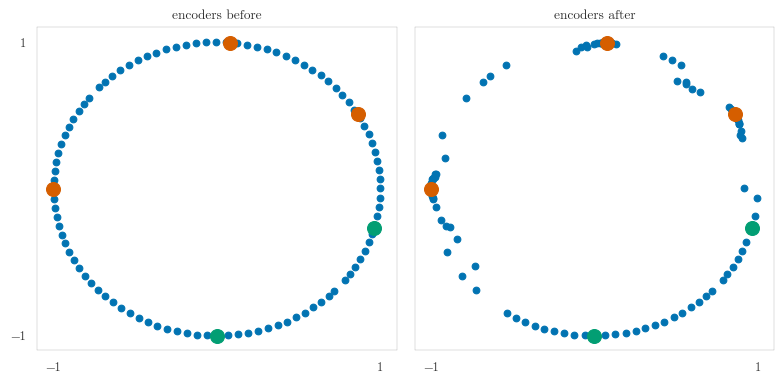

In [151]:
palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='white', font='CMU Serif', rc={'font.size':12, 'mathtext.fontset': 'cm', 'axes.linewidth': 0.1})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((8,4)), sharey=True)
for n in range(nCS):
    CS = inputs.CSs[n]
    c = palette[3] if inputs.USs[n] else palette[2]
    axes[0].scatter(CS[0], CS[1], zorder=1, color=c, s=100)
    axes[1].scatter(CS[0], CS[1], zorder=1, color=c, s=100)
axes[0].scatter(encoders_before[:,0], encoders_before[:,1], color=palette[0], zorder=0)
axes[1].scatter(encoders_after[:,0], encoders_after[:,1], color=palette[0], zorder=0)
axes[0].set(xticks=((-1,1)), xlim=((-1.1,1.1)), yticks=((-1,1)), ylim=((-1.1,1.1)), title='encoders before')
axes[1].set(xticks=((-1,1)), xlim=((-1.1,1.1)), yticks=((-1,1)), ylim=((-1.1,1.1)), title='encoders after')
plt.tight_layout()